# Image Segmentation with U-Net Model

## I. Download & Manipulate Dataset

### 1. Download dataset

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)

### 2. Load dataset

In [ ]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMAGE_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMAGE_SIZE)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMAGE_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMAGE_SIZE)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

### 3. Separate the train-test dataset

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## II. Dataset Ultility

### 1. Display the overall images

In [ ]:
import numpy as np
def display(display_list, visible_mask = np.array([True, True, True, True])):
    plt.figure(figsize=(20, 20))
    title = ["Input Image", "True Mask", "Predicted Mask", "Remove Background"]
    title = tf.boolean_mask(title, visible_mask).numpy().astype('str')
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

### Mask convert

In [ ]:
def convert_mask(t, target = 1.0):
    return tf.math.abs( 
        tf.math.subtract(
            t, 
            tf.convert_to_tensor(target, dtype=tf.float32) 
        ) 
    )

def remove_background(image, mask):
    msk = convert_mask(mask)
    return tf.math.multiply(image, msk)


### 3. Some example from train dataset

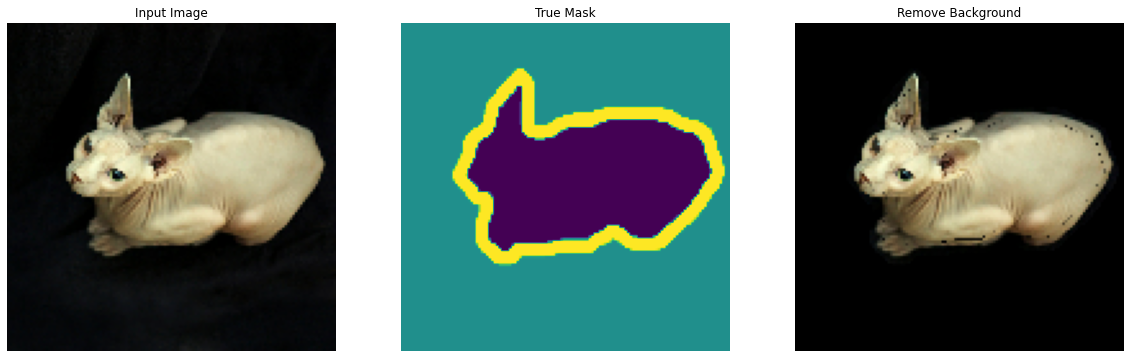

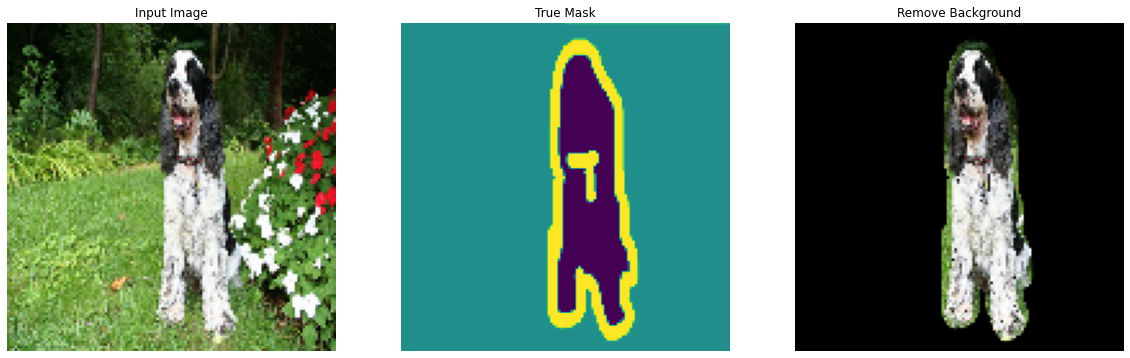

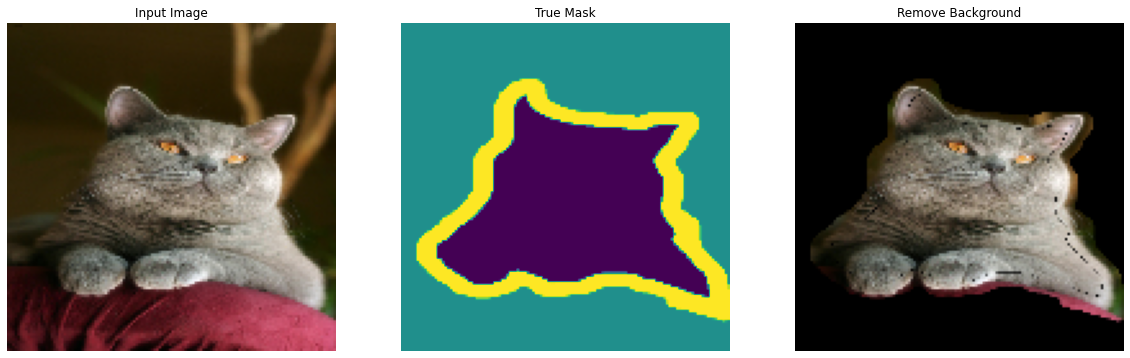

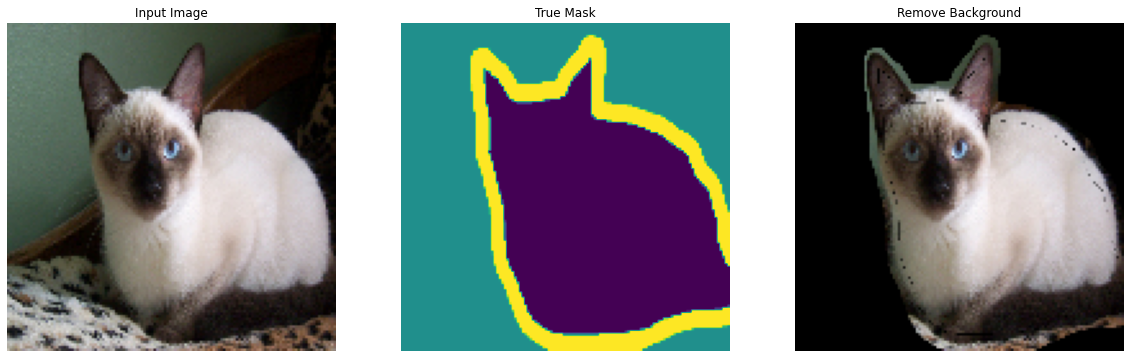

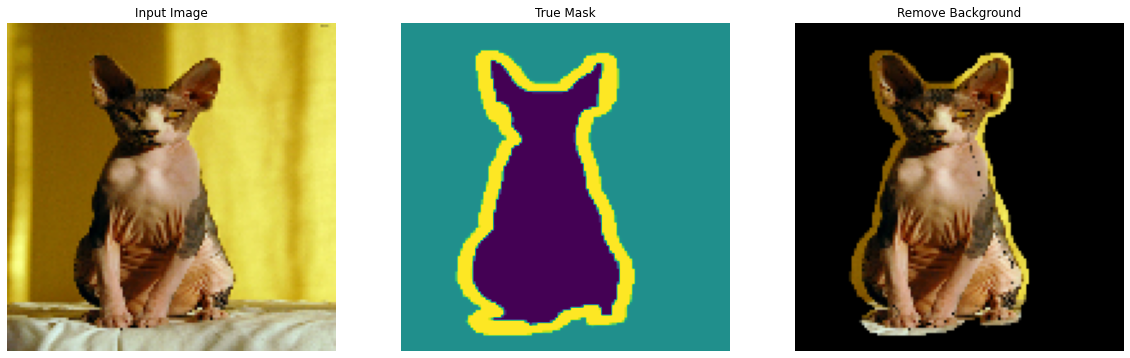

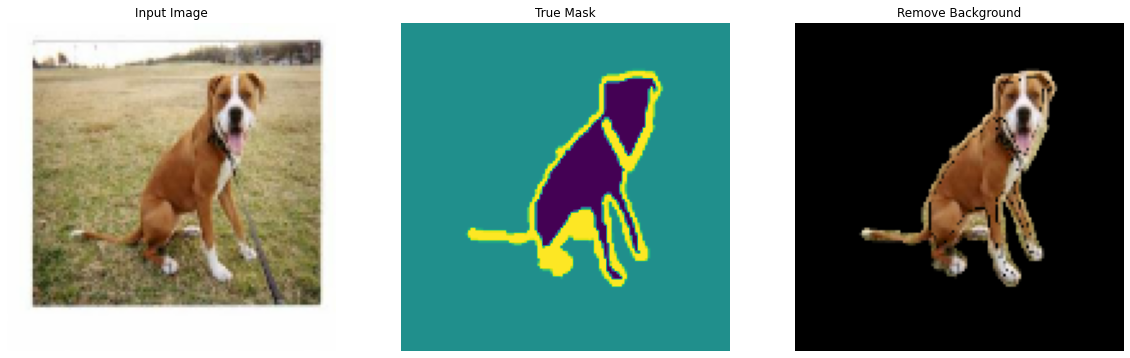

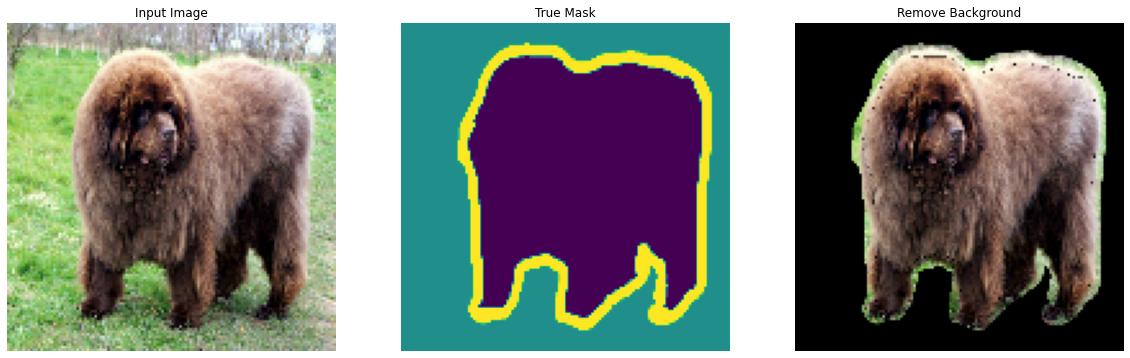

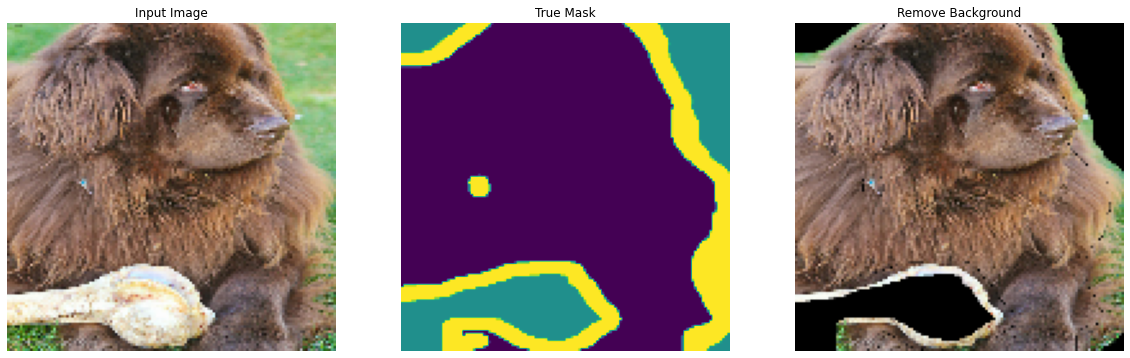

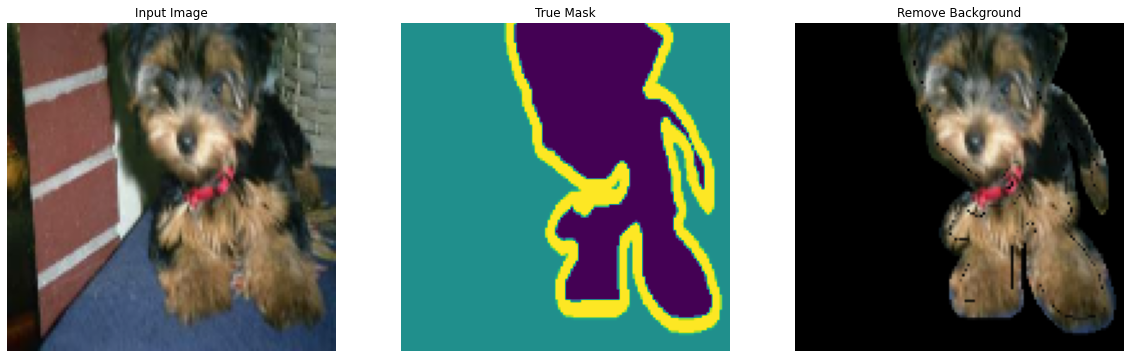

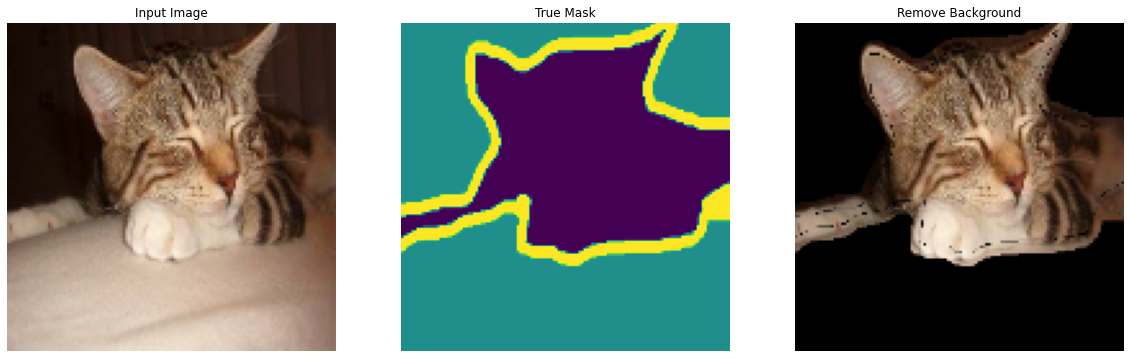

In [ ]:
for image, mask in train.take(10):
    sample_image, sample_mask = image, mask
    result = remove_background(image, mask)
    display([sample_image, sample_mask, result], [True, True, False, True])

## III. Construct model

### 1. U-Net model use MobileNetV2 Encode-Decode

In [ ]:
from tensorflow.keras.applications import MobileNetV2 as Pretrained_Model
from tensorflow.keras.layers import *

def unet_model(output_channels):

    base_model = Pretrained_Model(
        input_shape=INPUT_SHAPE, 
        include_top=False
    )

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_expand_relu',      # 4x4
    ]

    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=INPUT_SHAPE)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same'
    )  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### 2. U-Net model use MobileNetV3Large Encode-Decode

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large as Pretrained_Model_2
from tensorflow.keras.layers import *

def unet_model_2(output_channels):

    base_model = Pretrained_Model_2(
        input_shape=INPUT_SHAPE, 
        include_top=False
    )

    for index, layer in enumerate(base_model.layers):
        layer._name = 'mylayer_' + str(index)

    # Use the activations of these layers
    layer_names = [
        'mylayer_16',   # 64x64
        'mylayer_28',   # 32x32
        'mylayer_89',   # 16x16
        'mylayer_178',  # 8x8
        'mylayer_273'   # 4x4
    ]

    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=INPUT_SHAPE)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same'
    )  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## IV. Let's get started

### 1. Compile Model with Parameters

In [ ]:
OUTPUT_CHANNELS = 3
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model = unet_model(OUTPUT_CHANNELS)

optimizer = tf.keras.optimizers.Adam(
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.1,
        decay_steps=100000,
        decay_rate=0.95,
        staircase=True
    )
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### 2. Brief information of Model 

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_10 (Functional)           [(None, 64, 64, 96), 1522304     input_12[0][0]                   
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 8, 8, 512)    4425728     model_10[0][4]                   
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 8, 8, 1088)   0           sequential_20[0][0]              
                                                                 model_10[0][3]            

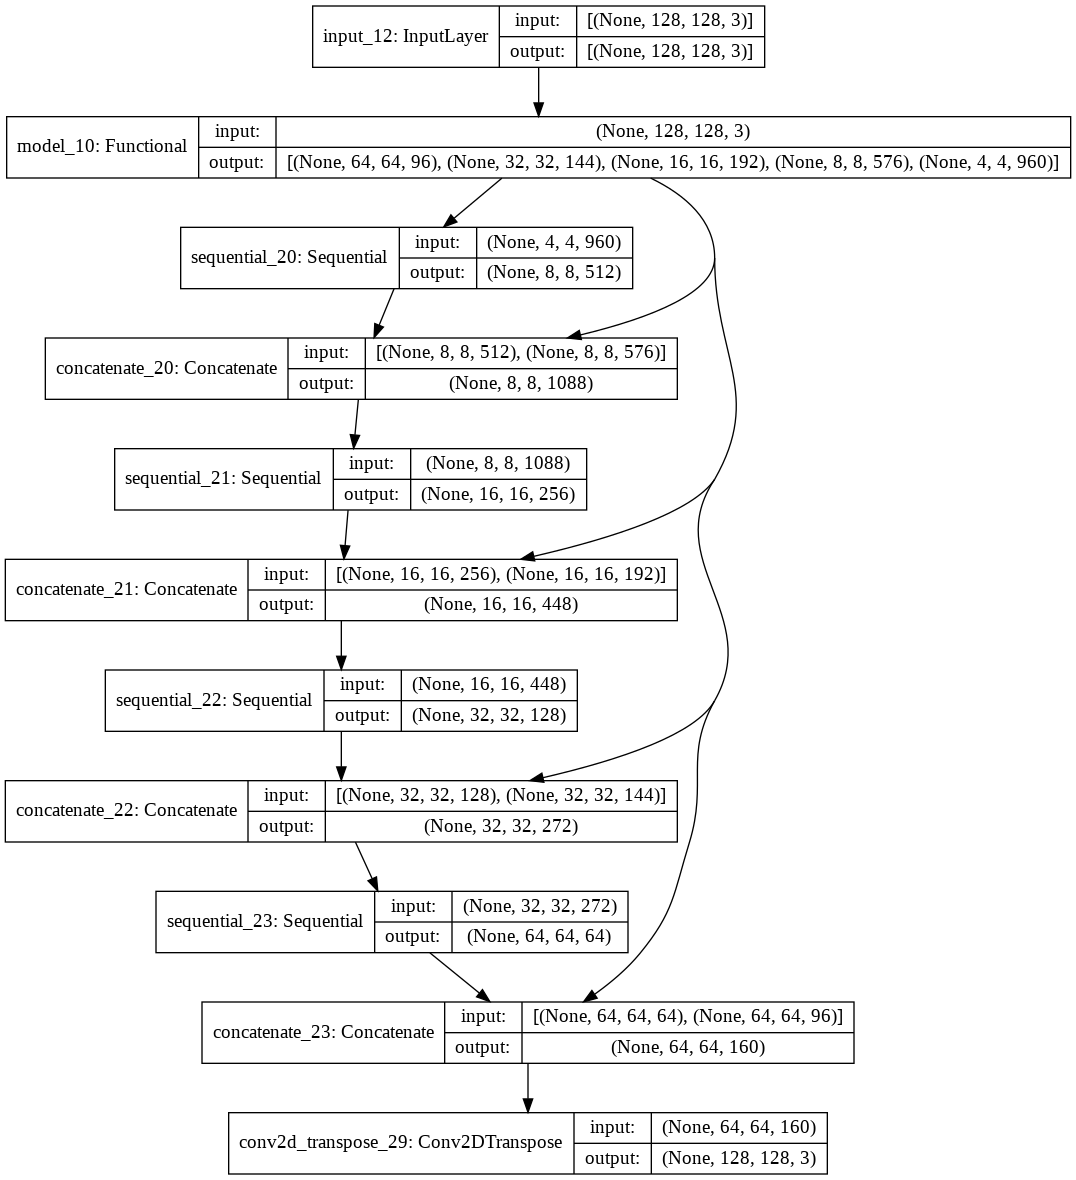

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 3. Training Model

In [ ]:
history = model.fit(
    train_dataset, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10),
    ]
)

Epoch 1/50
28/28 [==============================] - 16s 373ms/step - loss: 10.6720 - accuracy: 0.4629 - val_loss: 5.3501 - val_accuracy: 0.5228
Epoch 2/50
28/28 [==============================] - 6s 202ms/step - loss: 2.2825 - accuracy: 0.5248 - val_loss: 1.5111 - val_accuracy: 0.6034
Epoch 3/50
28/28 [==============================] - 5s 198ms/step - loss: 1.1205 - accuracy: 0.5889 - val_loss: 1.6184 - val_accuracy: 0.6065
Epoch 4/50
28/28 [==============================] - 6s 201ms/step - loss: 1.2124 - accuracy: 0.6056 - val_loss: 1.9353 - val_accuracy: 0.5877
Epoch 5/50
28/28 [==============================] - 6s 202ms/step - loss: 0.6223 - accuracy: 0.7731 - val_loss: 4.7601 - val_accuracy: 0.5664
Epoch 6/50
28/28 [==============================] - 6s 201ms/step - loss: 0.5881 - accuracy: 0.8276 - val_loss: 3.9575 - val_accuracy: 0.5669
Epoch 7/50
28/28 [==============================] - 6s 203ms/step - loss: 0.3957 - accuracy: 0.8509 - val_loss: 1.5291 - val_accuracy: 0.6490
Epoc

### 4. Model Evaluation

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
   
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = create_mask(model.predict(image))
            result = remove_background(
                image[0],
                tf.cast(pred_mask, tf.float32)
            )
            display([image[0], mask[0], pred_mask, result])
    else:
        pred_mask =  create_mask(model.predict(sample_image[tf.newaxis, ...]))
        # result = remove_background(sample_image, pred_mask)
        display([sample_image, sample_mask, pred_mask])

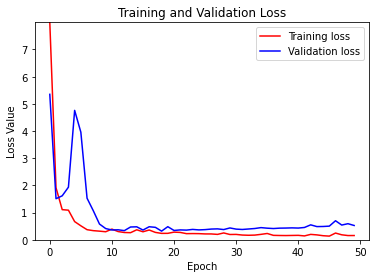

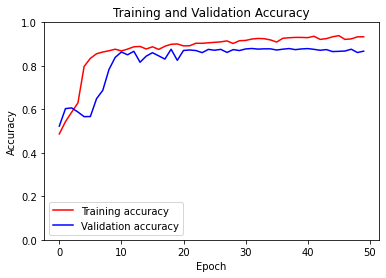

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, max(loss)])
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
model.evaluate(
    test_dataset, 
    batch_size=STEPS_PER_EPOCH
)

29/29 [==============================] - 9s 311ms/step - loss: 0.5386 - accuracy: 0.8687


[0.5386137366294861, 0.8687272667884827]

## V. Application in real example

### 1. From test dataset

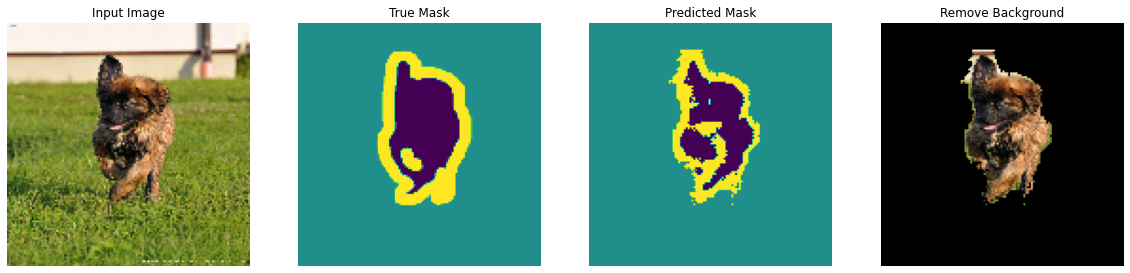

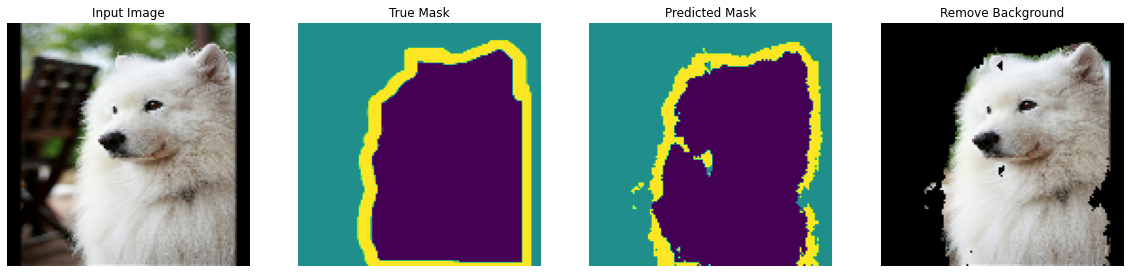

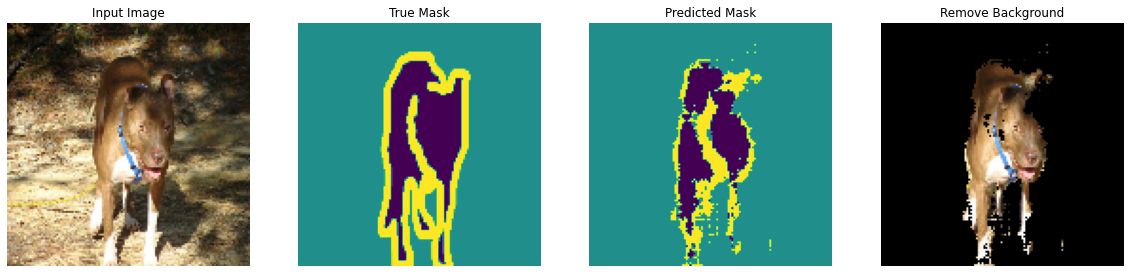

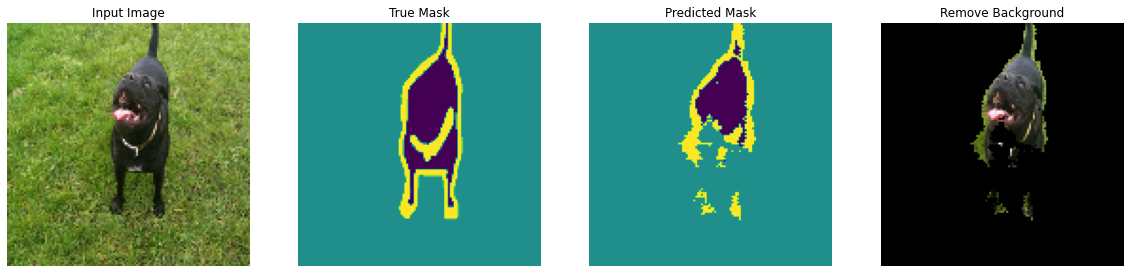

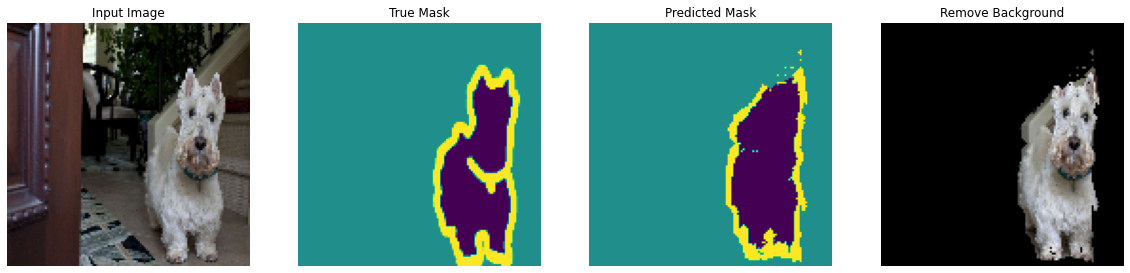

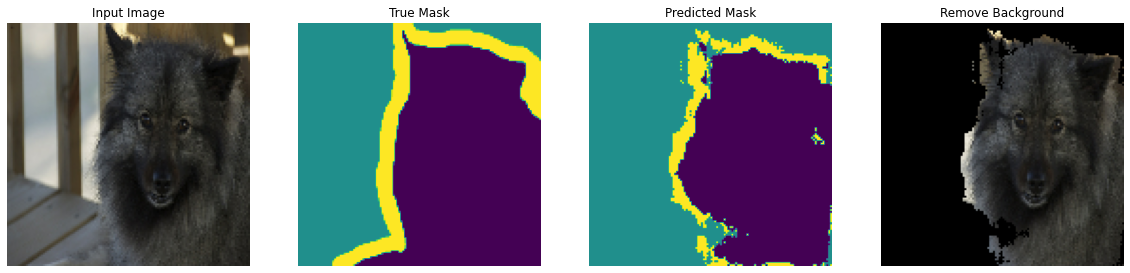

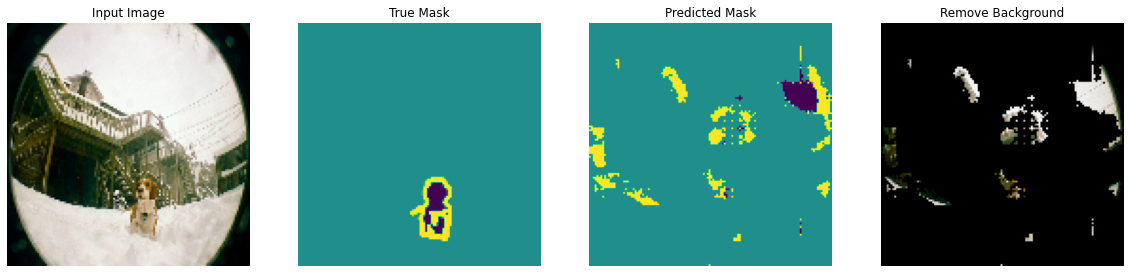

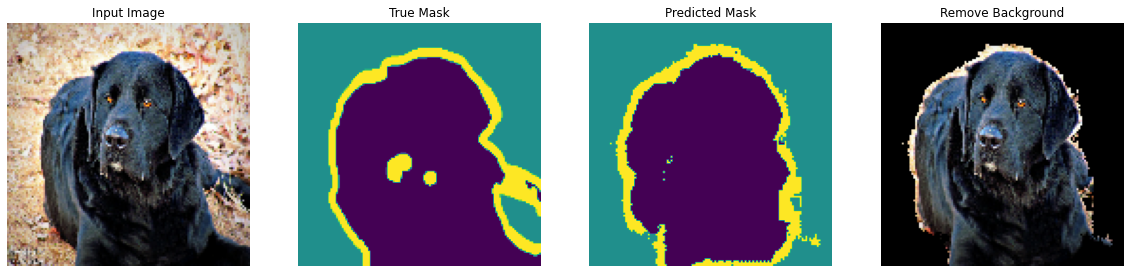

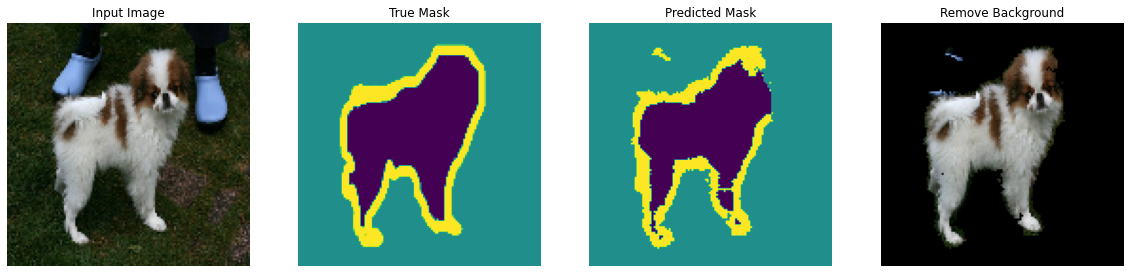

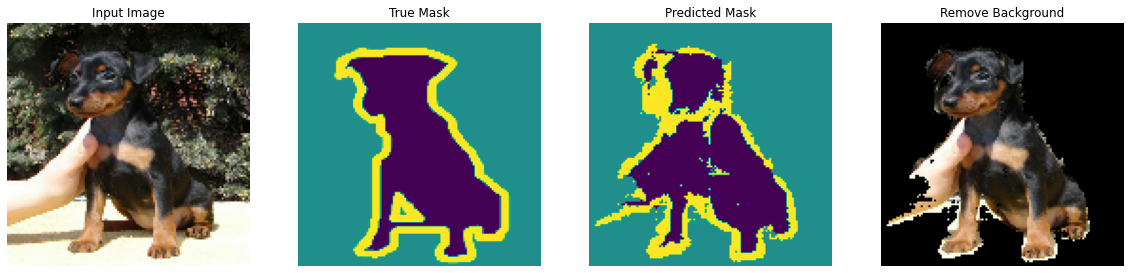

In [ ]:
show_predictions(test_dataset, 10)

### 2. Let try your example 

Saving images.jpg to images (1).jpg
saved file images.jpg


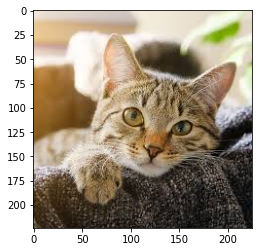

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab import files
uploaded = files.upload()

for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)

img = cv.imread(name)
img_cvt=cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

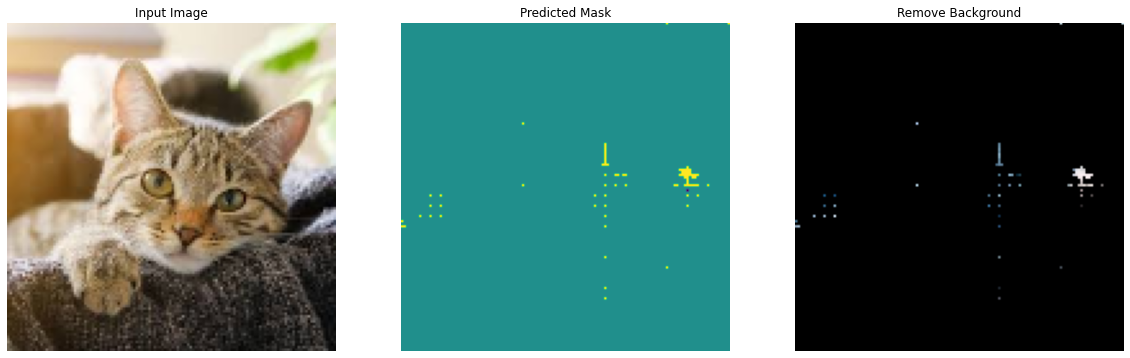

In [ ]:
resize_img = cv.resize(img, IMAGE_SIZE)

reshape_img = np.reshape(resize_img , (1, resize_img.shape[0], resize_img.shape[1], resize_img.shape[2]))

pred_mask = create_mask(model.predict(reshape_img))

result = remove_background(
    resize_img,
    tf.cast(pred_mask, tf.float32)
)

display([cv.cvtColor(resize_img, cv.COLOR_BGR2RGB), pred_mask, result], [True, False, True, True])